In [ ]:
# !pip install --upgrade tensorflow-io

In [2]:
import os
import numpy as np
import pandas as pd 
import random
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Conv2DTranspose, Concatenate, LeakyReLU, ReLU
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

strategy = tf.distribute.MirroredStrategy()

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
inputs_folder = "inputs"
outputs_folder = "outputs"
dataset_path = os.path.join(inputs_folder, 'TrainDataset')

# Define the image and mask paths
image_folder_path = os.path.join(dataset_path, 'image')
mask_folder_path = os.path.join(dataset_path, 'mask')

Number of images: 1450
Number of masks: 1450


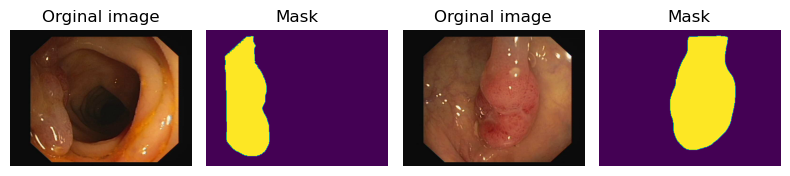

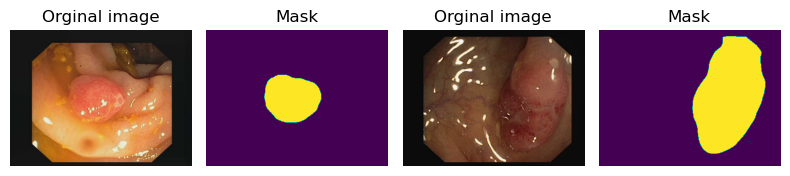

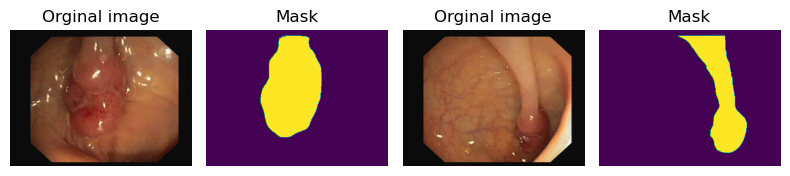

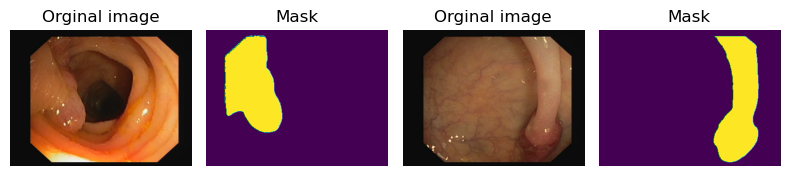

In [4]:
image_files_paths = sorted(
    [
        os.path.join(image_folder_path, fname)
        for fname in os.listdir(image_folder_path)
        if fname.endswith(".png")
    ]
)
mask_files_paths = sorted(
    [
        os.path.join(mask_folder_path, fname)
        for fname in os.listdir(mask_folder_path)
        if fname.endswith(".png")
    ]
)
print("Number of images:", len(image_files_paths))
print("Number of masks:", len(mask_files_paths))

# Display image(s)
for i in range(1, 12, 3):
    figure, ax = plt.subplots(nrows=1,ncols=4,figsize=(8,8))
    ax.ravel()[0].imshow(mpimg.imread(image_files_paths[i]))
    ax.ravel()[0].set_title("Orginal image")
    ax.ravel()[0].set_axis_off()
    ax.ravel()[1].imshow(mpimg.imread(mask_files_paths[i]))
    ax.ravel()[1].set_title("Mask")
    ax.ravel()[1].set_axis_off()
    
    ax.ravel()[2].imshow(mpimg.imread(image_files_paths[i+11]))
    ax.ravel()[2].set_title("Orginal image")
    ax.ravel()[2].set_axis_off()
    ax.ravel()[3].imshow(mpimg.imread(mask_files_paths[i+11]))
    ax.ravel()[3].set_title("Mask")
    ax.ravel()[3].set_axis_off()
    plt.tight_layout()

In [5]:
# Define the batch size and image dimensions
batch_size = 32
image_height = 256
image_width = 256
img_size = (image_height, image_width)

In [6]:
#some blocks of layers for the network
class ConvBlock(layers.Layer):
        def __init__(self, filters, kernel_size, strides=1, padding='same', drop_out_rate=0.1, pool=False):
            super().__init__()
            
            self.conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, kernel_initializer='he_normal')
            self.dropout = Dropout(drop_out_rate)
            self.norm = BatchNormalization()
            self.relu = LeakyReLU(0.1)

        def call(self, x):
            x = self.conv(x)
            x = self.norm(x)
            x = self.relu(x)
            x = self.dropout(x)
            return x
        

class UpConvBlock(layers.Layer):
    def __init__(self, filters, kernel_size, strides=2, padding='same', drop_out_rate=0.1):
            super().__init__()
#             self.concat_layer = concat_layer
            
            self.tconv = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)
            self.dropout = Dropout(drop_out_rate)
            self.norm = BatchNormalization()
            self.relu = ReLU()
            self.concat = Concatenate(axis=3)
    def call(self, x, y=None):
            x = self.tconv(x)
            if y != None:
                x = self.concat([x, y])
            x = self.norm(x)
            x = self.relu(x)
            x = self.dropout(x)
            return x   
            

In [7]:
#create model
with strategy.scope():
    inputs = tf.keras.layers.Input((image_height, image_width, 3))
    preprocessed =  tf.keras.layers.Lambda(lambda x: x / 255)(inputs) 

    conv1 = ConvBlock(16, 3)(preprocessed)
    conv1 = ConvBlock(16, 3)(conv1) 
    pool1 = MaxPooling2D((2,2))(conv1)

    conv2 = ConvBlock(32, 3)(pool1)
    conv2 = ConvBlock(32, 3)(conv2)
    pool2 = MaxPooling2D((2,2))(conv2)

    conv3 = ConvBlock(64, 3)(pool2)
    conv3 = ConvBlock(64, 3)(conv3)
    pool3 = MaxPooling2D((2,2))(conv3)

    conv4 = ConvBlock(128, 3)(pool3)
    conv4 = ConvBlock(128, 3)(conv4)
    pool4 = MaxPooling2D((2,2))(conv4)

    conv5 = ConvBlock(256, 3)(pool4)
    conv5 = ConvBlock(256, 3)(conv5)

    upconv6 = UpConvBlock(filters=128, kernel_size=2)(conv5, conv4)
    conv6 = ConvBlock(128, 3)(upconv6)
    conv6 = ConvBlock(128, 3)(conv6)

    upconv7 = UpConvBlock(filters=64, kernel_size=2)(conv6, conv3)
    conv7 = ConvBlock(64, 3)(upconv7)
    conv7 = ConvBlock(64, 3)(conv7)

    upconv8 = UpConvBlock(filters=32, kernel_size=2)(conv7, conv2)
    conv8 = ConvBlock(32, 3)(upconv8)
    conv8 = ConvBlock(32, 3)(conv8)

    upconv9 = UpConvBlock(filters=16, kernel_size=2)(conv8, conv1)
    conv9 = ConvBlock(16, 3)(upconv9)
    conv9 = ConvBlock(16, 3)(conv9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    # model = tf.keras.Model(inputs=[inputs], outputs=[conv4])
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv_block (ConvBlock)         (None, 256, 256, 16  512         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [8]:
val_samples = round(len(image_files_paths)*0.2)
train_input_img_paths = image_files_paths[:-val_samples]
train_target_img_paths = mask_files_paths[:-val_samples]
val_input_img_paths = image_files_paths[-val_samples:]
val_target_img_paths = mask_files_paths[-val_samples:]


In [9]:
# class PolypDatasetGenerator(keras.utils.Sequence):
#     def __init__(self, batch_size, img_size, image_paths, mask_paths):
#         self.batch_size = batch_size
#         self.img_size = img_size
#         self.image_paths = image_paths
#         self.mask_paths = mask_paths
#     def __len__(self):
#         return len(self.image_paths)
#     def __getitem__(self, idx):
#         i = idx * batch_size
#         batch_image_paths = self.image_paths[i : i + self.batch_size]
#         batch_mask_paths = self.mask_paths[i : i + self.batch_size]
        
#         x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
#         for j, path in enumerate(batch_image_paths):
#             x[j] = load_img(path, target_size=self.img_size)
            
#         y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="bool")
#         for j, path in enumerate(batch_mask_paths):
#             img = load_img(path, target_size=img_size, color_mode="grayscale")
# #             img = np.reshape(img, img_size + (1,))
# #             y[j] = img
#             y[j] = np.expand_dims(img, 2)
            
#         return x, y


In [10]:
def LoadPolypDataset(img_size, image_paths, mask_paths):
        x_count = 0;
        y_count = 0;
        x = np.zeros((len(image_paths),) + img_size + (3,), dtype="float32")
        for j, path in enumerate(image_paths):
            x[j] = load_img(path, target_size=img_size)
            x_count += 1
            print(f"Loaded {x_count} original images, latest image was from {path}                              ", end="", flush=True)
            print("\r", end="", flush=True)
        print("")
        
        y = np.zeros((len(image_paths),)  + img_size + (1,), dtype="bool")
        for j, path in enumerate(mask_paths):
            img = load_img(path, target_size=img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            y_count += 1
            print(f"Loaded {y_count} masks, latest mask was from {path}                                         ", end="", flush=True)
            print("\r", end="", flush=True)
        print("")
        
        return x, y

In [11]:
# train = PolypDatasetGenerator(batch_size, img_size, train_input_img_paths, train_target_img_paths)
# val = PolypDatasetGenerator(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [12]:
train = LoadPolypDataset(img_size, train_input_img_paths, train_target_img_paths)
val = LoadPolypDataset(img_size, val_input_img_paths, val_target_img_paths)

Loaded 1160 original images, latest image was from /kaggle/input/polyp-segmentation-datasets/TrainDataset/image/cju7ae7bq1f820987toc8si1d.png                              
Loaded 1160 masks, latest mask was from /kaggle/input/polyp-segmentation-datasets/TrainDataset/mask/cju7ae7bq1f820987toc8si1d.png                                         
Loaded 290 original images, latest image was from /kaggle/input/polyp-segmentation-datasets/TrainDataset/image/ck2da7fwcjfis07218r1rvm95.png                              
Loaded 290 masks, latest mask was from /kaggle/input/polyp-segmentation-datasets/TrainDataset/mask/ck2da7fwcjfis07218r1rvm95.png                                         


In [13]:
#Modelcheckpoint
with strategy.scope():

    callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
            tf.keras.callbacks.TensorBoard(log_dir=os.path.join(outputs_folder, 'logs')),
            tf.keras.callbacks.ModelCheckpoint(os.path.join(outputs_folder, 'checkpoint_model.h5'), verbose=1, save_best_only=True)]

    results = model.fit(x=train[0], y=train[1], batch_size=batch_size, validation_data=val, epochs=50, callbacks=callbacks)

Epoch 1/50


2023-07-05 17:26:38.174752: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/conv_block/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


37/37 [==============================] - ETA: 0s - loss: 0.4586 - accuracy: 0.7935
Epoch 1: val_loss improved from inf to 0.61835, saving model to /kaggle/working/checkpoint_model.h5
37/37 [==============================] - 69s 568ms/step - loss: 0.4586 - accuracy: 0.7935 - val_loss: 0.6183 - val_accuracy: 0.6570
Epoch 2/50
37/37 [==============================] - ETA: 0s - loss: 0.3304 - accuracy: 0.8730
Epoch 2: val_loss improved from 0.61835 to 0.49974, saving model to /kaggle/working/checkpoint_model.h5
37/37 [==============================] - 14s 385ms/step - loss: 0.3304 - accuracy: 0.8730 - val_loss: 0.4997 - val_accuracy: 0.7800
Epoch 3/50
37/37 [==============================] - ETA: 0s - loss: 0.2974 - accuracy: 0.8869
Epoch 3: val_loss improved from 0.49974 to 0.41486, saving model to /kaggle/working/checkpoint_model.h5
37/37 [==============================] - 15s 406ms/step - loss: 0.2974 - accuracy: 0.8869 - val_loss: 0.4149 - val_accuracy: 0.8177
Epoch 4/50
37/37 [=======

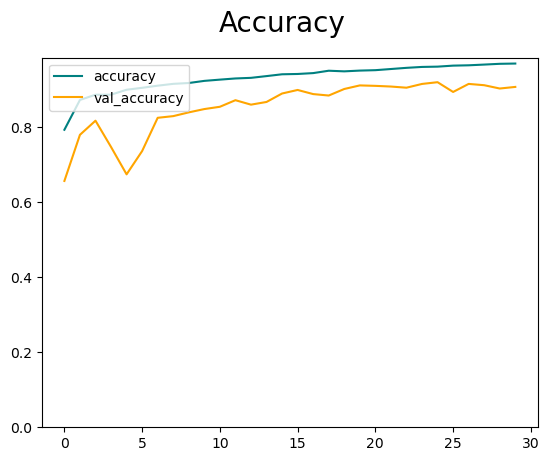

In [14]:
fig_acc=plt.figure()
plt.plot(results.history['accuracy'], color='teal', label='accuracy')
plt.plot(results.history['val_accuracy'], color='orange', label='val_accuracy')
fig_acc.suptitle('Accuracy', fontsize=20)
plt.ylim(ymin=0)  
plt.legend(loc="upper left")
plt.show()

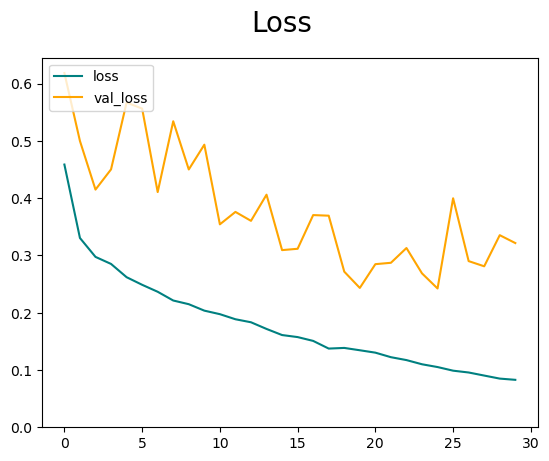

In [15]:
fig_loss=plt.figure()
plt.plot(results.history['loss'], color='teal', label='loss')
plt.plot(results.history['val_loss'], color='orange', label='val_loss')
fig_loss.suptitle('Loss', fontsize=20)
plt.ylim(ymin=0)  
plt.legend(loc="upper left")
plt.show()

In [16]:
#get test data
test_images_folder = os.path.join(inputs_folder, 'TestDataset/Kvasir/images')
test_masks_folder = os.path.join(inputs_folder, 'TestDataset/Kvasir/masks')
test_images_paths = sorted(
    [
        os.path.join(test_images_folder, fname)
        for fname in os.listdir(test_images_folder)
        if fname.endswith(".png")
    ]
)
test_masks_paths = sorted(
    [
        os.path.join(test_masks_folder, fname)
        for fname in os.listdir(test_masks_folder)
        if fname.endswith(".png")
    ]
)
test = LoadPolypDataset(img_size, test_images_paths, test_masks_paths)

Loaded 100 original images, latest image was from /kaggle/input/polyp-segmentation-datasets/TestDataset/Kvasir/images/cju8dqkrqu83i0818ev74qpxq.png                              
Loaded 100 masks, latest mask was from /kaggle/input/polyp-segmentation-datasets/TestDataset/Kvasir/masks/cju8dqkrqu83i0818ev74qpxq.png                                         


1/1 [==============================] - 1s 1s/step


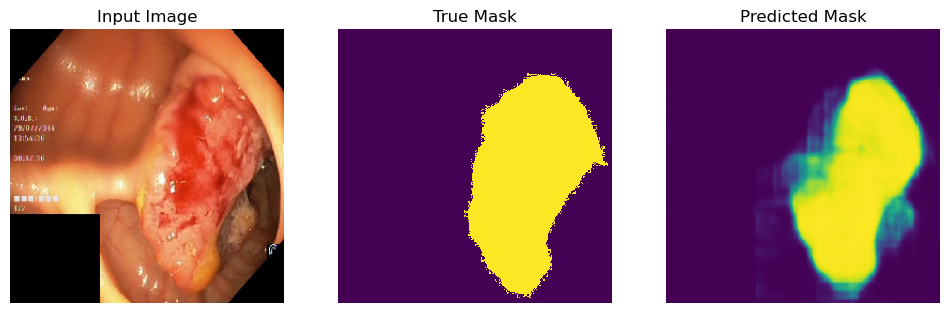

1/1 [==============================] - 0s 134ms/step


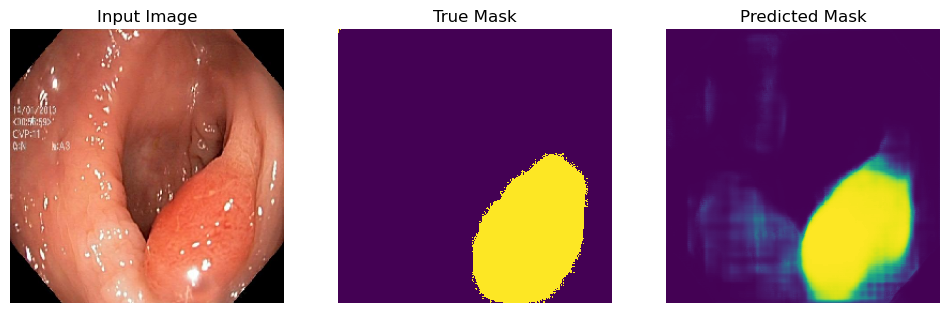

1/1 [==============================] - 0s 127ms/step


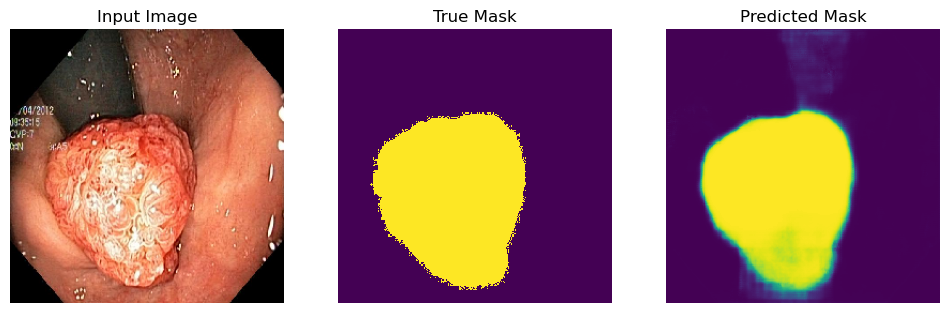

1/1 [==============================] - 0s 129ms/step


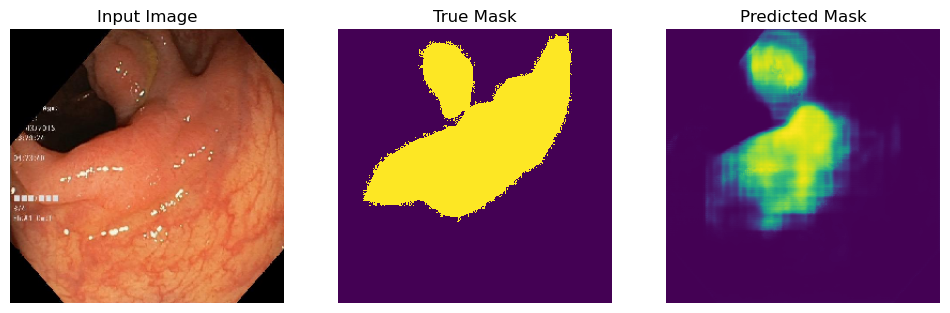

1/1 [==============================] - 0s 132ms/step


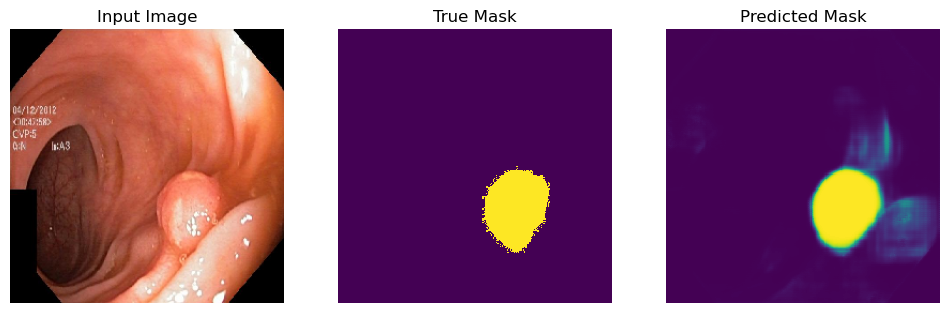

1/1 [==============================] - 0s 131ms/step


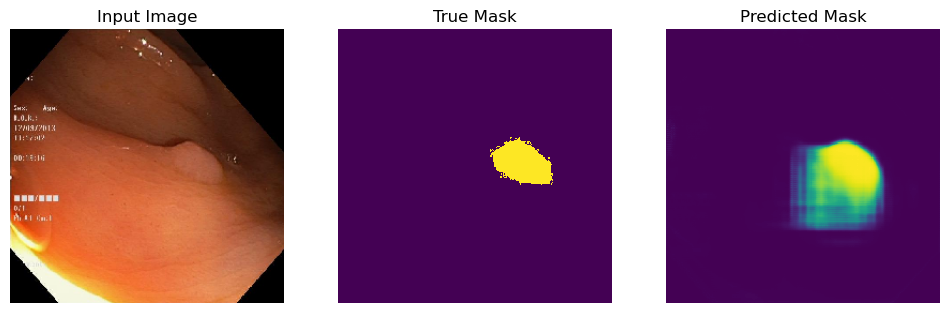

1/1 [==============================] - 0s 134ms/step


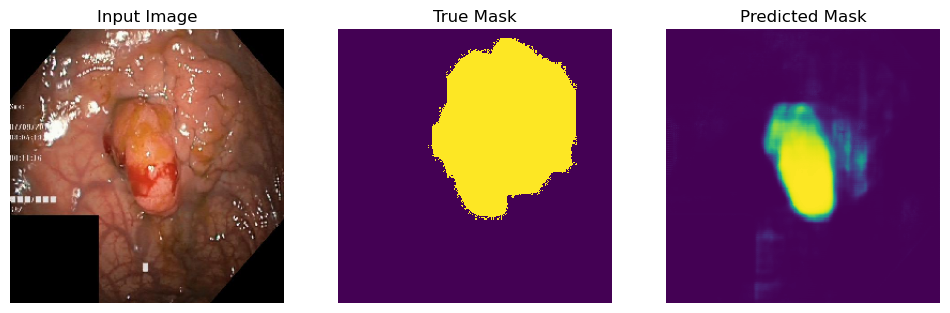

1/1 [==============================] - 0s 129ms/step


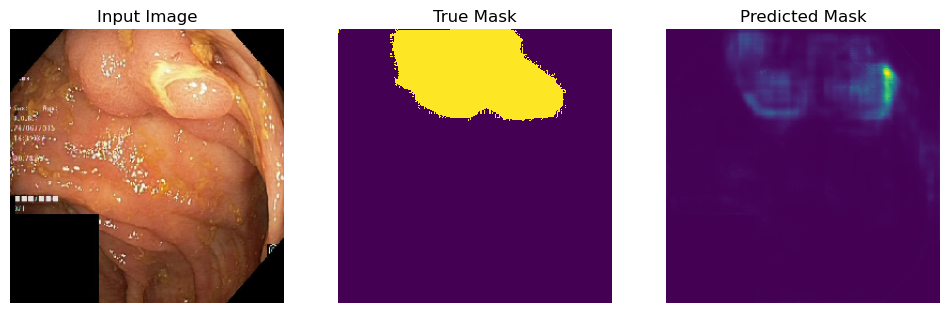

1/1 [==============================] - 0s 127ms/step


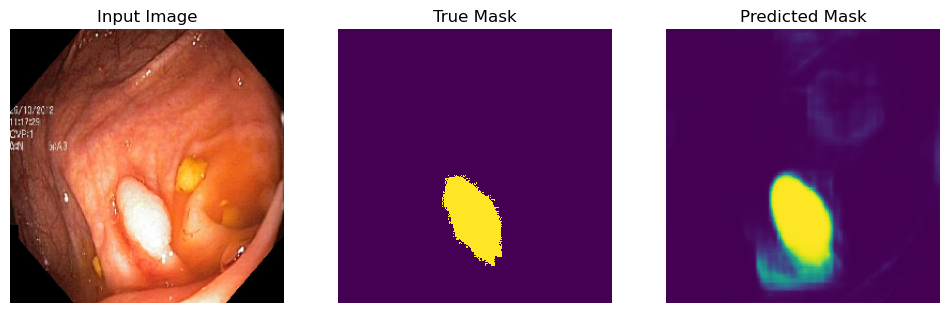

1/1 [==============================] - 0s 126ms/step


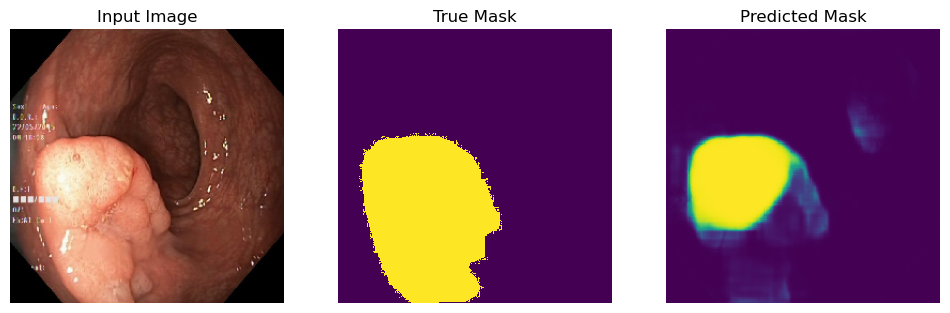

1/1 [==============================] - 0s 132ms/step
Precision:0.8295212984085083
Recall:0.6988876461982727
Accuracy: 0.9315357804298401


In [17]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
precision = Precision()
recall = Recall()
bin_accuracy = BinaryAccuracy()

for i in range(len(test_images_paths)):
    X = test[0][i]
    y = test[1][i]
    yhat = model.predict(X.reshape(1, image_height, image_width, 3))
    yhat = np.squeeze(yhat) 
    yhat = np.expand_dims(yhat, axis=-1)
    
    #plot the first 10 outputs
    if i < 10:
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Create a figure with three subplots in a row

        axes[0].imshow(X/255)
        axes[1].imshow(y, interpolation="nearest")
        axes[2].imshow(yhat, interpolation="nearest")

        axes[0].axis('off')  
        axes[1].axis('off')  
        axes[2].axis('off')  

        axes[0].set_title('Input Image')
        axes[1].set_title('True Mask')
        axes[2].set_title('Predicted Mask')
    
    plt.show()
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    bin_accuracy.update_state(y, yhat)
print(f'Precision:{precision.result().numpy()}')
print(f'Recall:{recall.result().numpy()}')
print(f'Accuracy: {bin_accuracy.result().numpy()}')

In [18]:
saved_model = model.save(os.path.join(outputs_folder, 'polyp_model.h5'))